こちらをもとに学習<br>
https://www.kaggle.com/code/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert

#　ライブラリのインポート

In [1]:
import gc
import re
import string
import operator
from collections import defaultdict

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
import seaborn as sns

import tokenization
from wordcloud import STOPWORDS

from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import precision_score, recall_score, f1_score

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback

SEED = 1337


# stringモジュール・・・アスキー文字や数字などの特定の文字種。句読点、文字区切り系。スペースや改行などが格納されている。

2022-12-11 09:41:34.197646: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
train_df = pd.read_csv('nlp-getting-started/train.csv')
test_df = pd.read_csv('nlp-getting-started/test.csv')

print('Training Set Shape = {}'.format(train_df.shape))
print('Test Set Shape = {}'.format(test_df.shape))

Training Set Shape = (7613, 5)
Test Set Shape = (3263, 4)


In [3]:
print('訓練データ')
train_df.head()

訓練データ


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
print('テストデータ')
test_df.head()

テストデータ


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


### データセットのカラムについて
・id・・・ツイートの一意なキー<br>・text・・・ツイートの文<br>・location・・・ツイートがどこから送られたか<br>
・keyword・・・ツイートのキーワード<br>・target・・・災害についてのツイートだったら「1」、そうでなければ「0」

# 【keywordとlocationについて】

## 欠損値について

keywordとlocationカラムでは、訓練データセットとテストデータセットは同じ割合の欠損値を所持している。<br>
* keywordカラムの全体の0.8%が欠損値となっている。
* locationカラムの全体の33%が欠損値となっている。

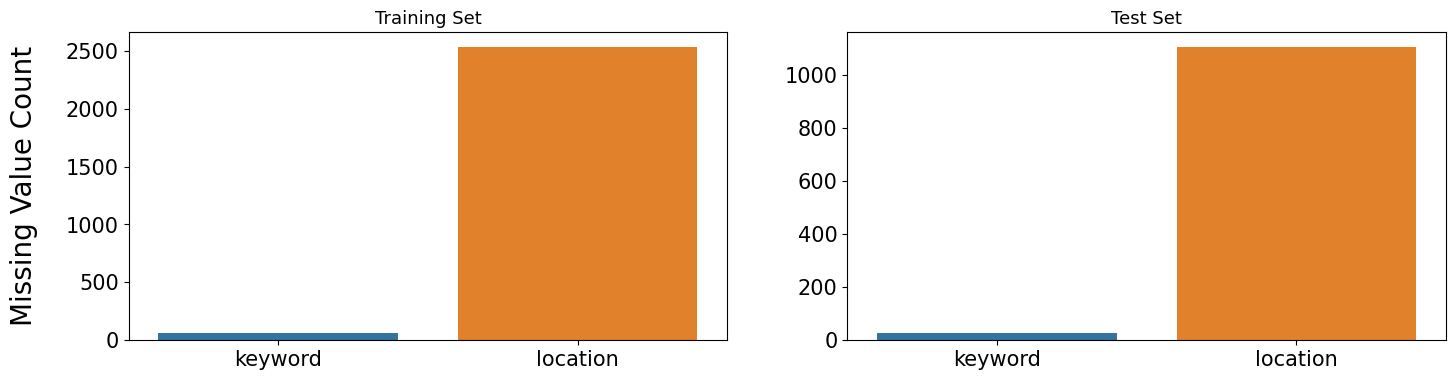

In [5]:
# 欠損値を数えるカラムをmissing_cols変数に入れる。
missing_cols = ['keyword', 'location']

fig, ax = plt.subplots(1, 2, figsize=(17, 4), dpi=100)
# plt.subplots_adjust(wspace=0.3, hspace=0.2)

background_color = '#f6f5f5'

sns.barplot(x=train_df[missing_cols].isnull().sum().index, y=train_df[missing_cols].isnull().sum().values, ax=ax[0])
sns.barplot(x=test_df[missing_cols].isnull().sum().index, y=test_df[missing_cols].isnull().sum().values, ax=ax[1])

ax[0].set_ylabel('Missing Value Count', size=20, labelpad=20)

# tick_paramsで目盛りの細かい調整。
ax[0].tick_params(axis='x', labelsize=15)
ax[0].tick_params(axis='y', labelsize=15)
ax[1].tick_params(axis='x', labelsize=15)
ax[1].tick_params(axis='y', labelsize=15)

ax[0].set_title('Training Set', fontsize=13)
ax[1].set_title('Test Set', fontsize=13)

plt.show()

for df in [train_df, test_df]:
    for col in ['keyword', 'location']:
        df[col] = df[col].fillna(f'no_{col}')

## カーディナリティと目的変数の分布

Locationはユーザーのインプットで自動的に生成された。<br>
Locationカラムは表記の揺れなどで、ユニークな値が多く、特徴量に使われるべきではない。<br>

### カーディナリティについて

In [6]:
print(f'keywordカラムのユニークな値 = {train_df["keyword"].nunique()} (Training) - {test_df["keyword"].nunique()} (Test)')
print(f'locationカラムのユニークな値 = {train_df["location"].nunique()} (Training) - {test_df["location"].nunique()} (Test)')

keywordカラムのユニークな値 = 222 (Training) - 222 (Test)
locationカラムのユニークな値 = 3342 (Training) - 1603 (Test)


### 目的変数の分布について

下記のヒストグラムで、tweetにどのkeywordが使われていると、targetが1(災害に関すること）に分類されているか<br>
targetが0(災害に関係ないこと）に分類されているか読み取れる。

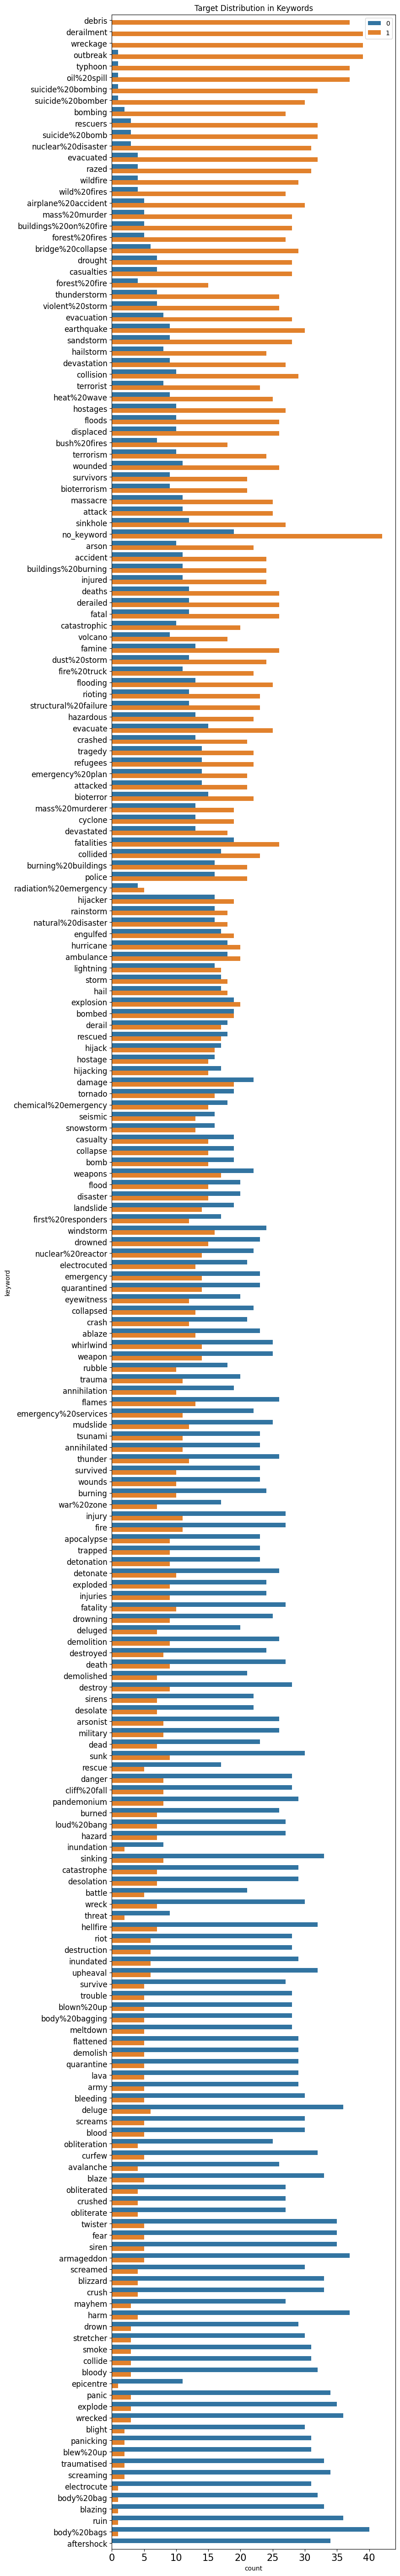

In [7]:
train_df['target_mean'] = train_df.groupby('keyword')['target'].transform('mean')

fig = plt.figure(figsize=(8, 72), dpi=100)

# countplotメソッドは、データの件数を集計し、ヒストグラムとして出力する。
# └hue・・・各軸をさらに分割して、集計する場合に利用する列名を指定。
# yにデータフレームを入れると横方向に、xに入れると縦方向になる。
sns.countplot(y=train_df.sort_values(by='target_mean', ascending=False)['keyword']
              , hue=train_df.sort_values(by='target_mean', ascending=False)['target'])

plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=12)
plt.legend(loc=1)
plt.title('Target Distribution in Keywords')

plt.show()

# 作成したtarget_meanはtrain_dfデータフレームから除去しておく。
# train_df.drop(columns=['target_mean'], inplace=True)

(感じたこと)<br>
カラム内の値毎に,同じ表の中にヒストグラムを可視化するなら、seabornのcountplotを使った方が良い気がする。<br>
同じfig内で、異なるaxesにヒストグラムを可視化するなら、matplotlib.pyplotのsubplotsを使った方が良い気がする。

Meta Feature(メタ特徴量)とは<br>
「あるモデルによる予測値」を最終的な予測を行うモデルの特徴量とするとき、その特徴量のことをMeta Featureと言う。<br>
https://zenn.dev/chimuichimu/articles/42719df8f7e197

メタ特徴量の分布は災害ツイートの特定に役にたつ。<br>
災害ツイートのほとんどは、ニュース媒介物から来るため、災害ツイートではないものと比べて、長くフォーマルに書かれているように見える。<br>
個人のアカウントからツイートされるため、災害ツイートではない災害ツイートではないツイートは災害ツイートよりもタイプミスが多い<br>

In [8]:
# Seriesの各要素に関数を適用：map(), apply()

# テキスト内の単語の数
train_df['word_count'] = train_df['text'].apply(lambda x: len(str(x).split()))
test_df['word_count'] = test_df['text'].apply(lambda x: len(str(x).split()))

# テキスト内の一意な単語の数
# setは中身が重複しない配列を返す。
train_df['unique_word_count'] = train_df['text'].apply(lambda x: len(set(str(x).split())))
test_df['unique_word_count'] = test_df['text'].apply(lambda x: len(set(str(x).split())))

# stopwordsの数
train_df['stop_word_count'] = train_df['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
test_df['stop_word_count'] = test_df['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

# テキスト内のURLの数
train_df['url_count'] = train_df['text'].apply(lambda x: len([w for w in str(x).lower().split(x) if 'http' in w or 'https' in w]))
test_df['url_count'] = test_df['text'].apply(lambda x: len([w for w in str(x).lower().split(x) if 'http' in w or 'https' in w]))

# テキスト内の平均文字数
train_df['mean_word_length'] = train_df['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test_df['mean_word_length'] = test_df['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# テキスト内の文字数カウント
train_df['char_count'] = train_df['text'].apply(lambda x: len(str(x)))
test_df['char_count'] = test_df['text'].apply(lambda x: len(str(x)))

# テキストの中の句読点の数
train_df['punctuation_count'] = train_df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
test_df['punctuation_count'] = test_df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# テキストの中のハッシュタグ（#)の数
train_df['hashtag_count'] = train_df['text'].apply(lambda x: len([c for c in str(x) if c == '#']))
test_df['hashtag_count'] = test_df['text'].apply(lambda x: len([c for c in str(x) if c == '#']))

# テキストの中のメンション「@」の数
train_df['mention_count'] = train_df['text'].apply(lambda x: len([c for c in str(x) if c == '@']))
test_df['mention_count'] = test_df['text'].apply(lambda x: len([c for c in str(x) if c == '@']))

すべてのメタ特徴量は、トレーニング セットとテスト セットで非常によく似た分布を持っています。<br>これは、トレーニングセットとテストセットが同じサンプルから取得されたことも証明しています。

すべてのメタ特徴量にはターゲットに関する情報も含まれていますが、url_count、hashtag_count、mention_countなどの一部は十分ではありません。

一方、word_count、unique_word_count、stop_word_count、mean_word_length、char_count、punctuation_count は、災害ツイートと非災害ツイートの分布が大きく異なります。 これらの機能は、モデルで役立つ場合があります。

/var/folders/h_/nlz7m_v57ls6456wjyb923100000gn/T/ipykernel_27941/2364810867.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_df.loc[~DISASTER_TWEETS][feature], label='Not Disaster', ax=ax[i][0], kde=True, color='#ffb6c1')
/var/folders/h_/nlz7m_v57ls6456wjyb923100000gn/T/ipykernel_27941/2364810867.py:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.git

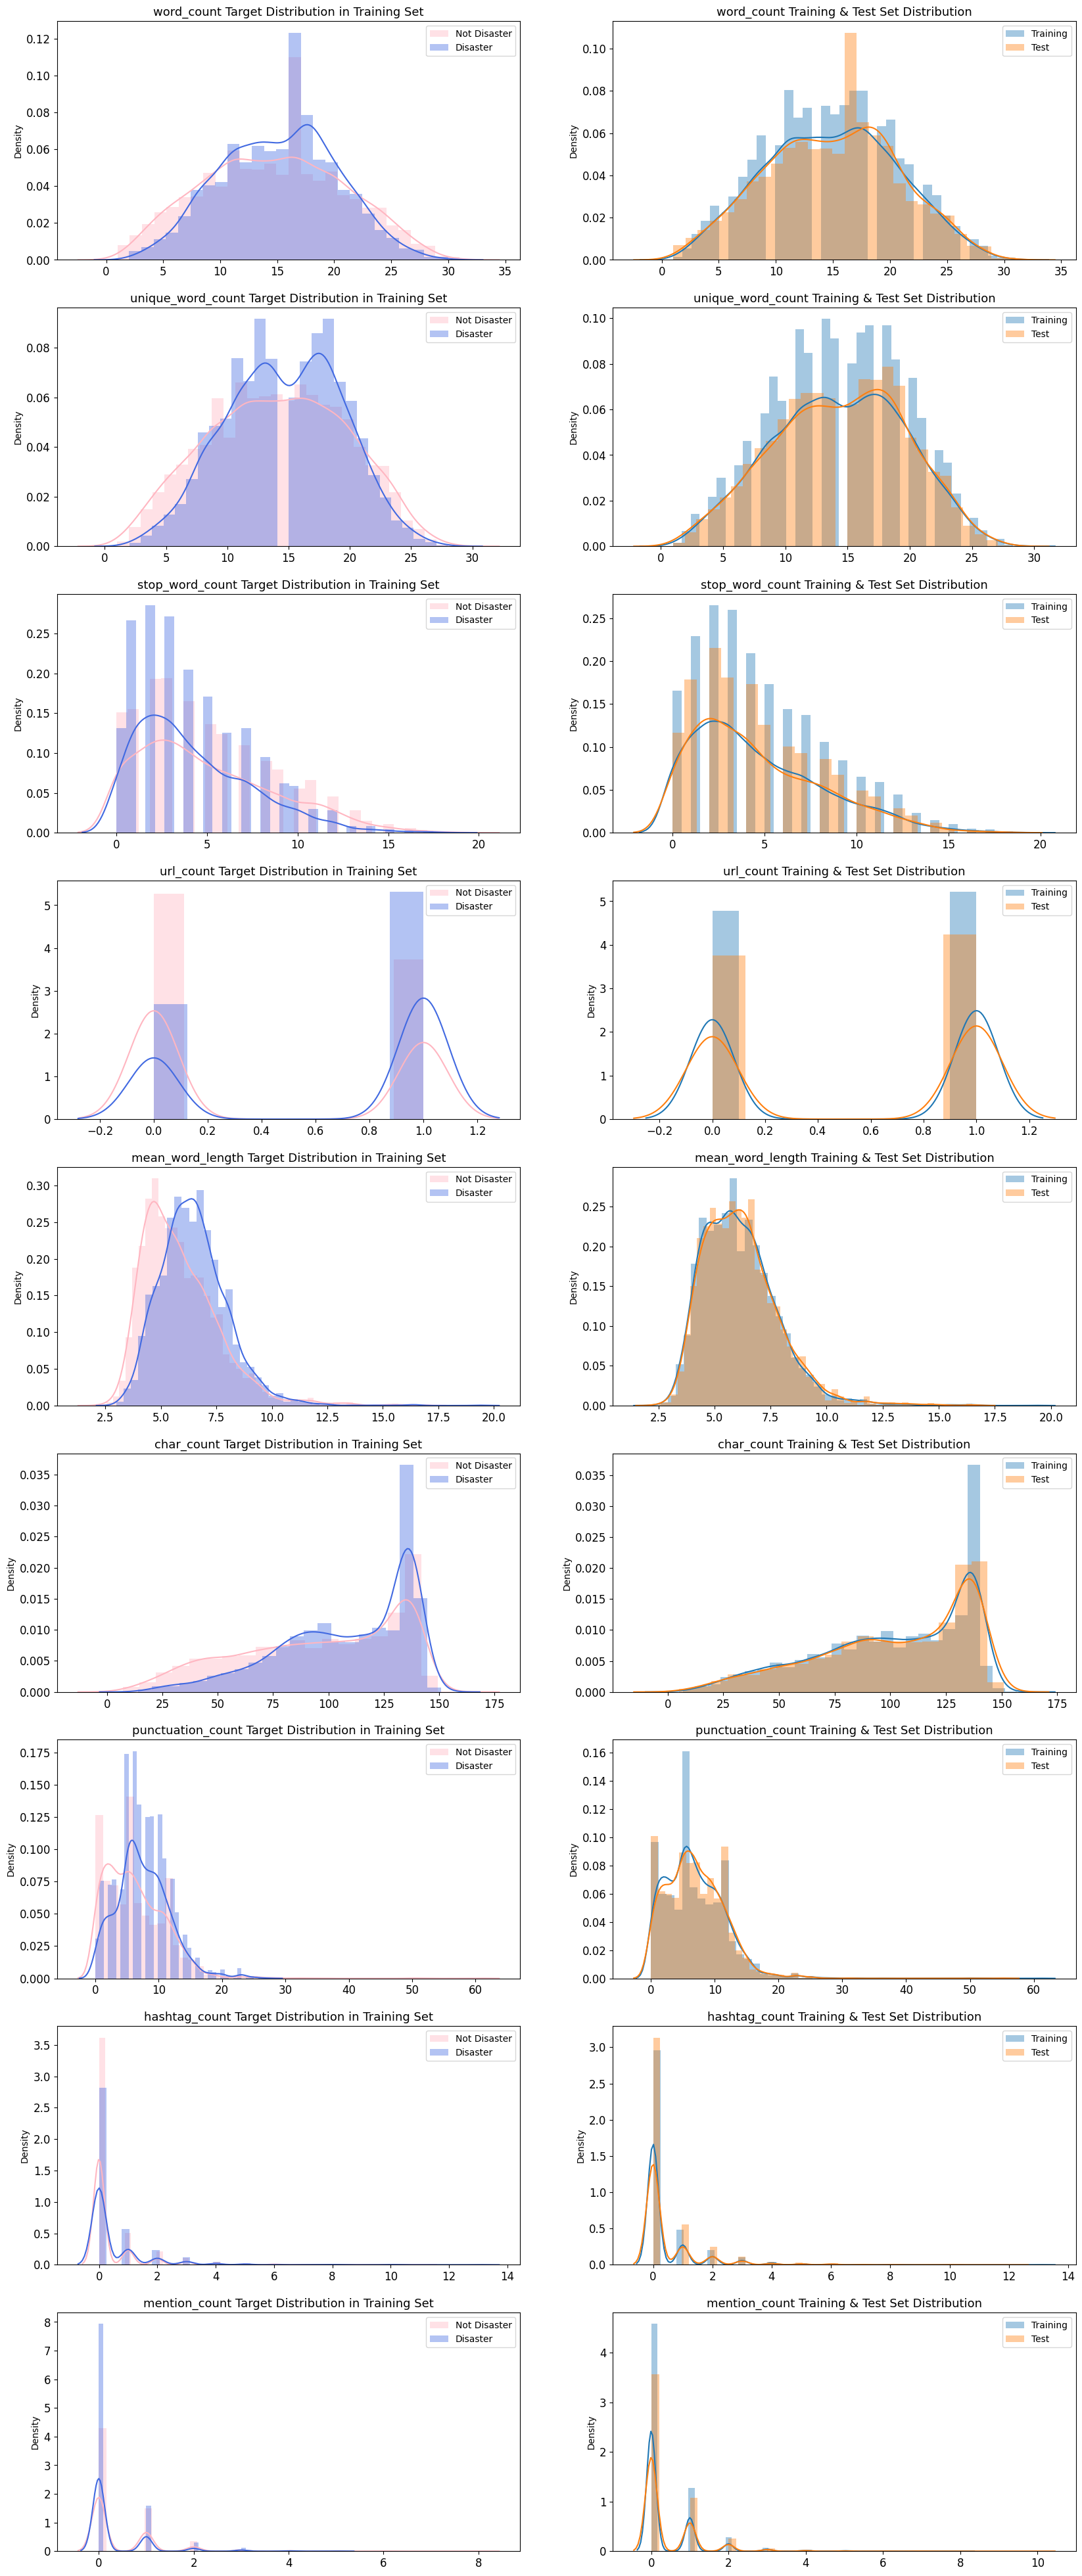

In [9]:
# seabornのdistplot・・・ヒストグラムを描写する。
# [~DISASTER_TWEETS]の~は否定演算子。[DISASTER_TWEETS==False]と同義

METAFEATURES = ['word_count', 'unique_word_count', 'stop_word_count', 'url_count', 'mean_word_length',
                'char_count', 'punctuation_count', 'hashtag_count', 'mention_count']

DISASTER_TWEETS = train_df['target']==1

fig,ax = plt.subplots(ncols=2, nrows=len(METAFEATURES), figsize=(20, 50), dpi=100)

for i, feature in enumerate(METAFEATURES):
    sns.distplot(train_df.loc[~DISASTER_TWEETS][feature], label='Not Disaster', ax=ax[i][0], kde=True, color='#ffb6c1')
    sns.distplot(train_df.loc[DISASTER_TWEETS][feature], label='Disaster', ax=ax[i][0], kde=True, color='#4169e1')
    
    sns.distplot(train_df[feature], label='Training', ax=ax[i][1])
    sns.distplot(test_df[feature], label='Test', ax=ax[i][1])
    
    for j in range(2):
        ax[i][j].set_xlabel('')
        ax[i][j].tick_params(axis='x', labelsize=12)
        ax[i][j].tick_params(axis='y', labelsize=12)
        ax[i][j].legend()
        
    ax[i][0].set_title(f'{feature} Target Distribution in Training Set', fontsize=13)
    ax[i][1].set_title(f'{feature} Training & Test Set Distribution', fontsize=13)
    
plt.show()

/var/folders/h_/nlz7m_v57ls6456wjyb923100000gn/T/ipykernel_27941/2364810867.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_df.loc[~DISASTER_TWEETS][feature], label='Not Disaster', ax=ax[i][0], kde=True, color='#ffb6c1')
/var/folders/h_/nlz7m_v57ls6456wjyb923100000gn/T/ipykernel_27941/2364810867.py:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.git

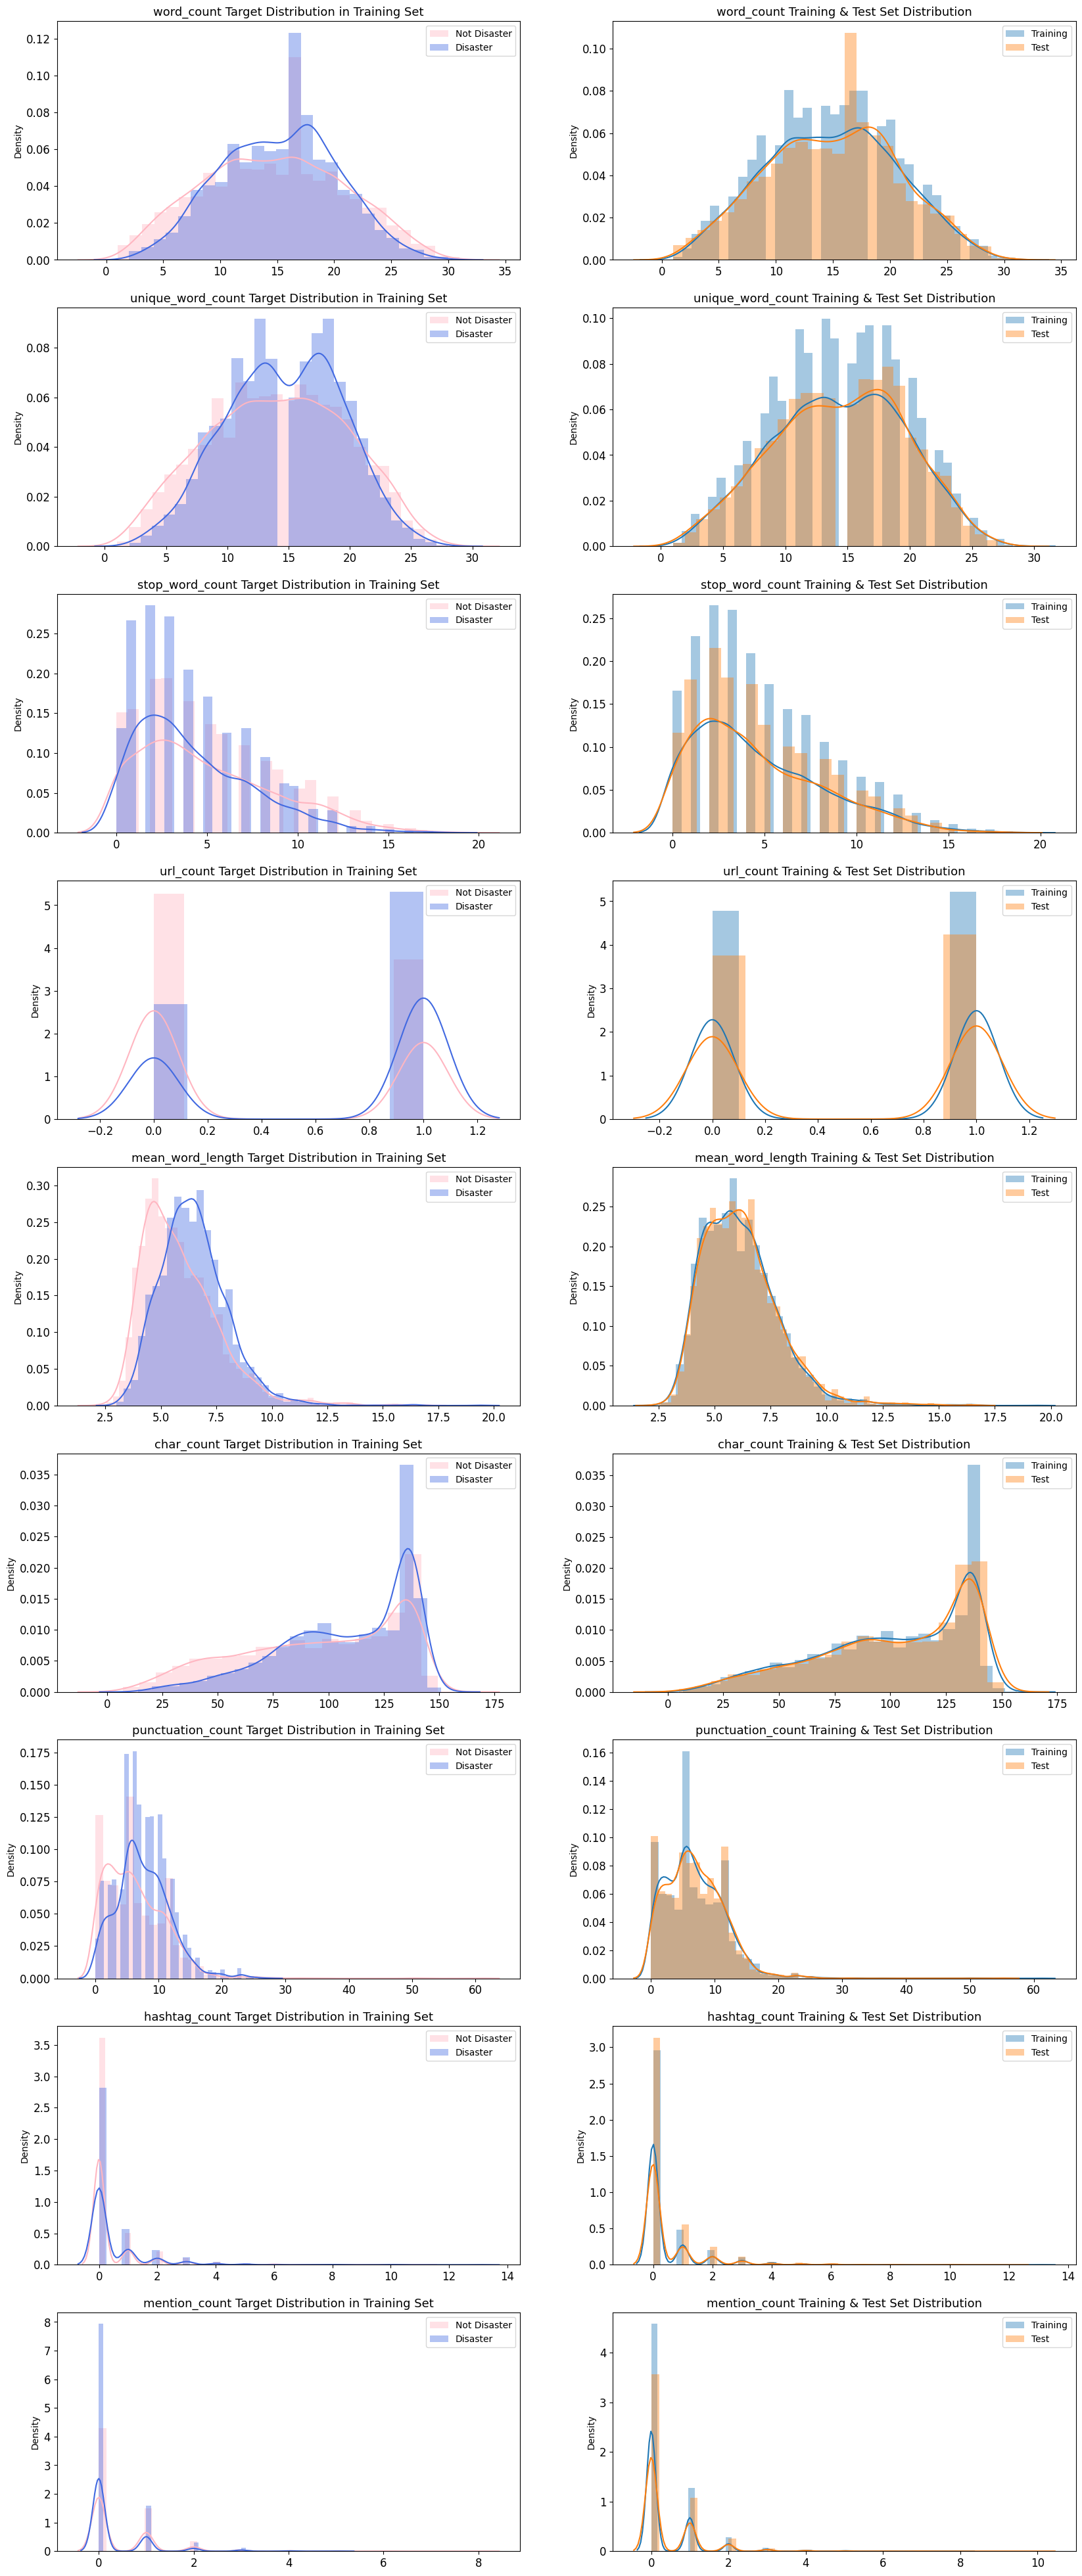

In [10]:
# seabornのdistplot・・・ヒストグラムを描写する。
# [~DISASTER_TWEETS]の~は否定演算子。[DISASTER_TWEETS==False]と同義

METAFEATURES = ['word_count', 'unique_word_count', 'stop_word_count', 'url_count', 'mean_word_length',
                'char_count', 'punctuation_count', 'hashtag_count', 'mention_count']

DISASTER_TWEETS = train_df['target']==1

fig,ax = plt.subplots(ncols=2, nrows=len(METAFEATURES), figsize=(20, 50), dpi=100)

for i, feature in enumerate(METAFEATURES):
    sns.distplot(train_df.loc[~DISASTER_TWEETS][feature], label='Not Disaster', ax=ax[i][0], kde=True, color='#ffb6c1')
    sns.distplot(train_df.loc[DISASTER_TWEETS][feature], label='Disaster', ax=ax[i][0], kde=True, color='#4169e1')
    
    sns.distplot(train_df[feature], label='Training', ax=ax[i][1])
    sns.distplot(test_df[feature], label='Test', ax=ax[i][1])
    
    for j in range(2):
        ax[i][j].set_xlabel('')
        ax[i][j].tick_params(axis='x', labelsize=12)
        ax[i][j].tick_params(axis='y', labelsize=12)
        ax[i][j].legend()
        
    ax[i][0].set_title(f'{feature} Target Distribution in Training Set', fontsize=13)
    ax[i][1].set_title(f'{feature} Training & Test Set Distribution', fontsize=13)
    
plt.show()

# 目的変数とN-gram

## 目的変数

In [11]:
train_df['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

([<matplotlib.patches.Wedge at 0x1315b9880>,
 [Text(-0.24110481617711207, -1.0732513534192263, 'Non-Disaster'),
  Text(0.24110481617711216, 1.0732513534192263, 'Disaster')],
 [Text(-0.1534303375672531, -0.682978133994053, '57.0%'),
  Text(0.1534303375672532, 0.682978133994053, '43.0%')])

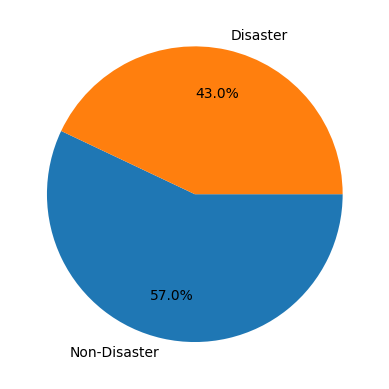

In [12]:
label = ['Non-Disaster', 'Disaster']
plt.pie(train_df['target'].value_counts(), counterclock=False, autopct='%1.1f%%', pctdistance=0.7, labels=label)

<AxesSubplot: xlabel='target', ylabel='count'>

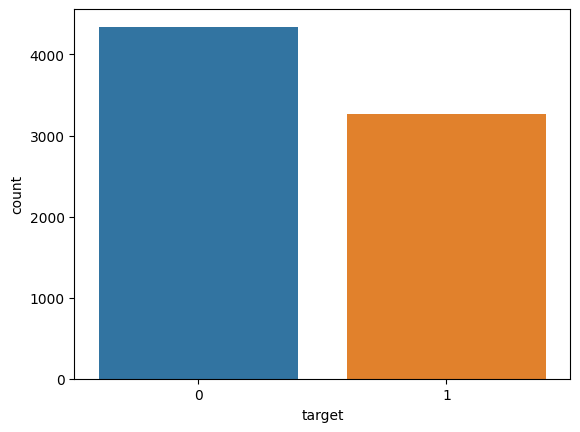

In [13]:
sns.countplot(x='target', data=train_df)

In [ ]:
# # plt.tight_layout()・・・サブプロット間の正しい間隔を自動的に維持する。
# fig, ax = plt.subplots(ncols=len(train_df['target']), figsize=(17, 4), dpi=100)
# plt.tight_layout()
                       
# train_df.groupby('target').count()['id'].plot(kind='pie', ax=ax[0], labels=['Not Disaster (57%)', 'Disaster(43%)'])
# sns.countplot(x=train_df['target'], hue=train_df['target'], ax=ax[1])

# ax[0].set_ylabel('')
# ax[1].set_ylabel('')
# ax[1].set_xticklabels(['Not Disaster (4342)', 'Disaster (3271)'])
# ax[0].tick_params(axis='x', labelsize=15)
# ax[0].tick_params(axis='y', labelsize=15)
# ax[1].tick_params(axis='x', labelsize=15)
# ax[1].tick_params(axis='y', labelsize=15)

# ax[0].set_title('Target Distribution in Training Set', fontsize=13)
# ax[1].set_title('Target Count in Training Set', fontsize=13)

# plt.show()

In [29]:
# zip関数・・・複数のリストを同時に取得したい場合に使用する関数。引数に(*)を付けると、unzip（元のイテラブル)に分解することが可能。
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(' ') if token != '' if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

N = 100

# ユニグラム・・・１単語単位で区切ったもの
disaster_unigrams = defaultdict(int)
nondisaster_unigrams = defaultdict(int)


# pythonにはdictという辞書を扱う型が存在する。dictは「key:value」の組みを保持する型。キーが存在しない場合はエラーが発生する。
# collectionsモジュールのdefaultdict・・・キーが存在しないことによるエラーを防ぐのはもちろん、キーが存在しない場合は新しい要素を追加してくれる。（存在しないキーを設定して値を取得しようとすると、設定した引数の初期値が帰ってくる。intの場合は0を返す。）        
for tweet in train_df[DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet):
        disaster_unigrams[word] += 1

for tweet in train_df[~DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet):
        nondisaster_unigrams[word] += 1
        
# items()・・・辞書型のデータのキーと値を取得する方法。
# for k, v in d.items():・・・kにキー。vに値を取得できる
# sortedのkeyではlambda x: x[1]となっている・・・disaster_unigramsのインデックス番号「１」つまり二番目の値でソートされているというイメージ。
# DataFrame[::-1]・・・データフレームや配列の中の要素がリバースする(DataFrame[::]は、中の要素を全指定。）
df_disaster_unigrams = pd.DataFrame(sorted(disaster_unigrams.items(), key=lambda x: x[1])[::-1])
df_nondisaster_unigrams = pd.DataFrame(sorted(nondisaster_unigrams.items(), key=lambda x: x[1])[::-1])


# バイグラム・・・２単語単位で区切ったもの
disaster_bigrams = defaultdict(int)
nondisaster_bigrams = defaultdict(int)

for tweet in train_df[DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet, n_gram=2):
        disaster_bigrams[word] += 1
        
for tweet in train_df[~DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet, n_gram=2):
        nondisaster_bigrams[word] += 1
        
df_disaster_bigrams = pd.DataFrame(sorted(disaster_bigrams.items(), key=lambda x: x[1])[::-1])
df_nondisaster_bigrams = pd.DataFrame(sorted(nondisaster_bigrams.items(), key=lambda x: x[1])[::-1])
        

# トライグラム・・・３単語単位で区切ったもの
disaster_trigrams = defaultdict(int)
nondisaster_trigrams = defaultdict(int)

for tweet in train_df[DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet, n_gram=3):
        disaster_trigrams[word] += 1
        
for tweet in train_df[~DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet, n_gram=3):
        nondisaster_trigrams[word] += 1
        
df_disaster_trigrams = pd.DataFrame(sorted(disaster_trigrams.items(), key=lambda x: x[1])[::-1])
df_nondisaster_trigrams = pd.DataFrame(sorted(nondisaster_trigrams.items(), key=lambda x: x[1])[::-1])

In [26]:
df_disaster_unigrams.head()

,0,1
0,-,389
1,fire,150
2,via,117
3,...,105
4,&amp;,105


## ユニグラム

両方のクラスに存在する最も一般的なユニグラムは、ほとんどが句読点、ストップワード、または数字。<br>ターゲットに関する情報があまり得られないため、モデリングの前にそれらを綺麗にした方が良い。
<br>
<br>
災害に関するツイートの中で最も一般的なユニグラムは、すでに災害について情報を与えている。<br>
それらの単語を別の文脈で使用することは非常に難しい。
<br>
<br>
災害以外のツイートの中で最も一般的なユニグラムは動詞。<br>これらの文のほとんどは、個々のユーザーからのものであるため、非公式なアクティブな構造を持っているため、理にかなっている。

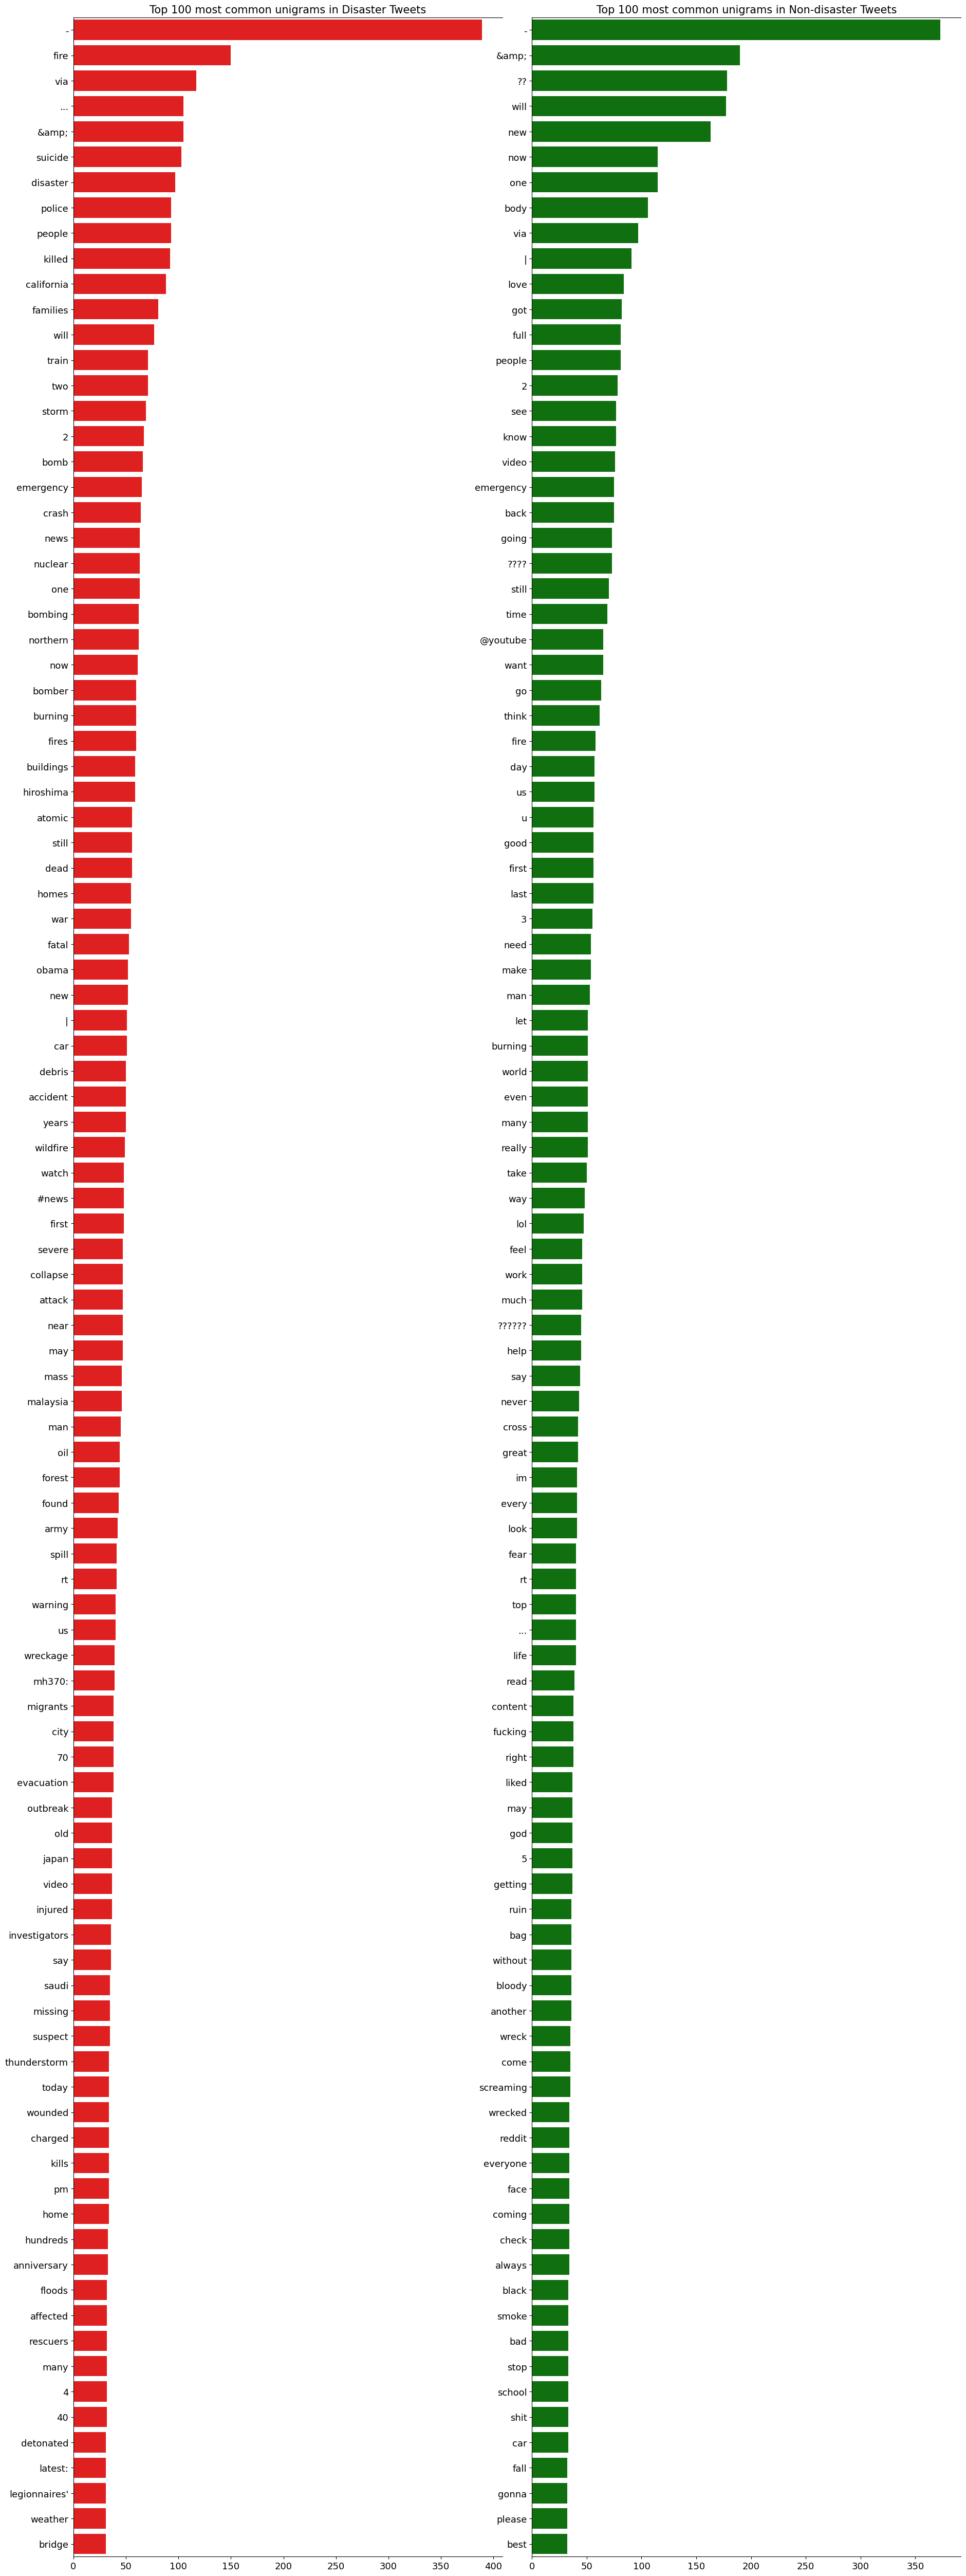

In [27]:
fig, axes = plt.subplots(ncols=2, figsize=(18, 50), dpi=100)
plt.tight_layout()

sns.barplot(y=df_disaster_unigrams[0].values[:N], x=df_disaster_unigrams[1].values[:N], ax=axes[0], color='red')
sns.barplot(y=df_nondisaster_unigrams[0].values[:N], x=df_nondisaster_unigrams[1].values[:N], ax=axes[1], color='green')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

axes[0].set_title(f'Top {N} most common unigrams in Disaster Tweets', fontsize=15)
axes[1].set_title(f'Top {N} most common unigrams in Non-disaster Tweets', fontsize=15)

plt.show()

## バイグラム

文脈がより明確なため、両方のクラスに共通のバイグラムは存在しない。
<br>
<br>
災害ツイートの中の最も一般的なバイグラムのツイートは、災害についてユニグラムよりも多くの情報を与えている。<br>
しかし、句読点は削除する必要がある。
<br>
<br>
非災害ツイートの中の最も一般的なバイグラムのツイートは、主にredditまたはユーチューブについてで、彼らは多くの句読点を含んでいる。<br>
それらの句読点も除去する必要がある。

/Users/yamaguchiayumiyume/.pyenv/versions/3.8.5/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 137 (\x89) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


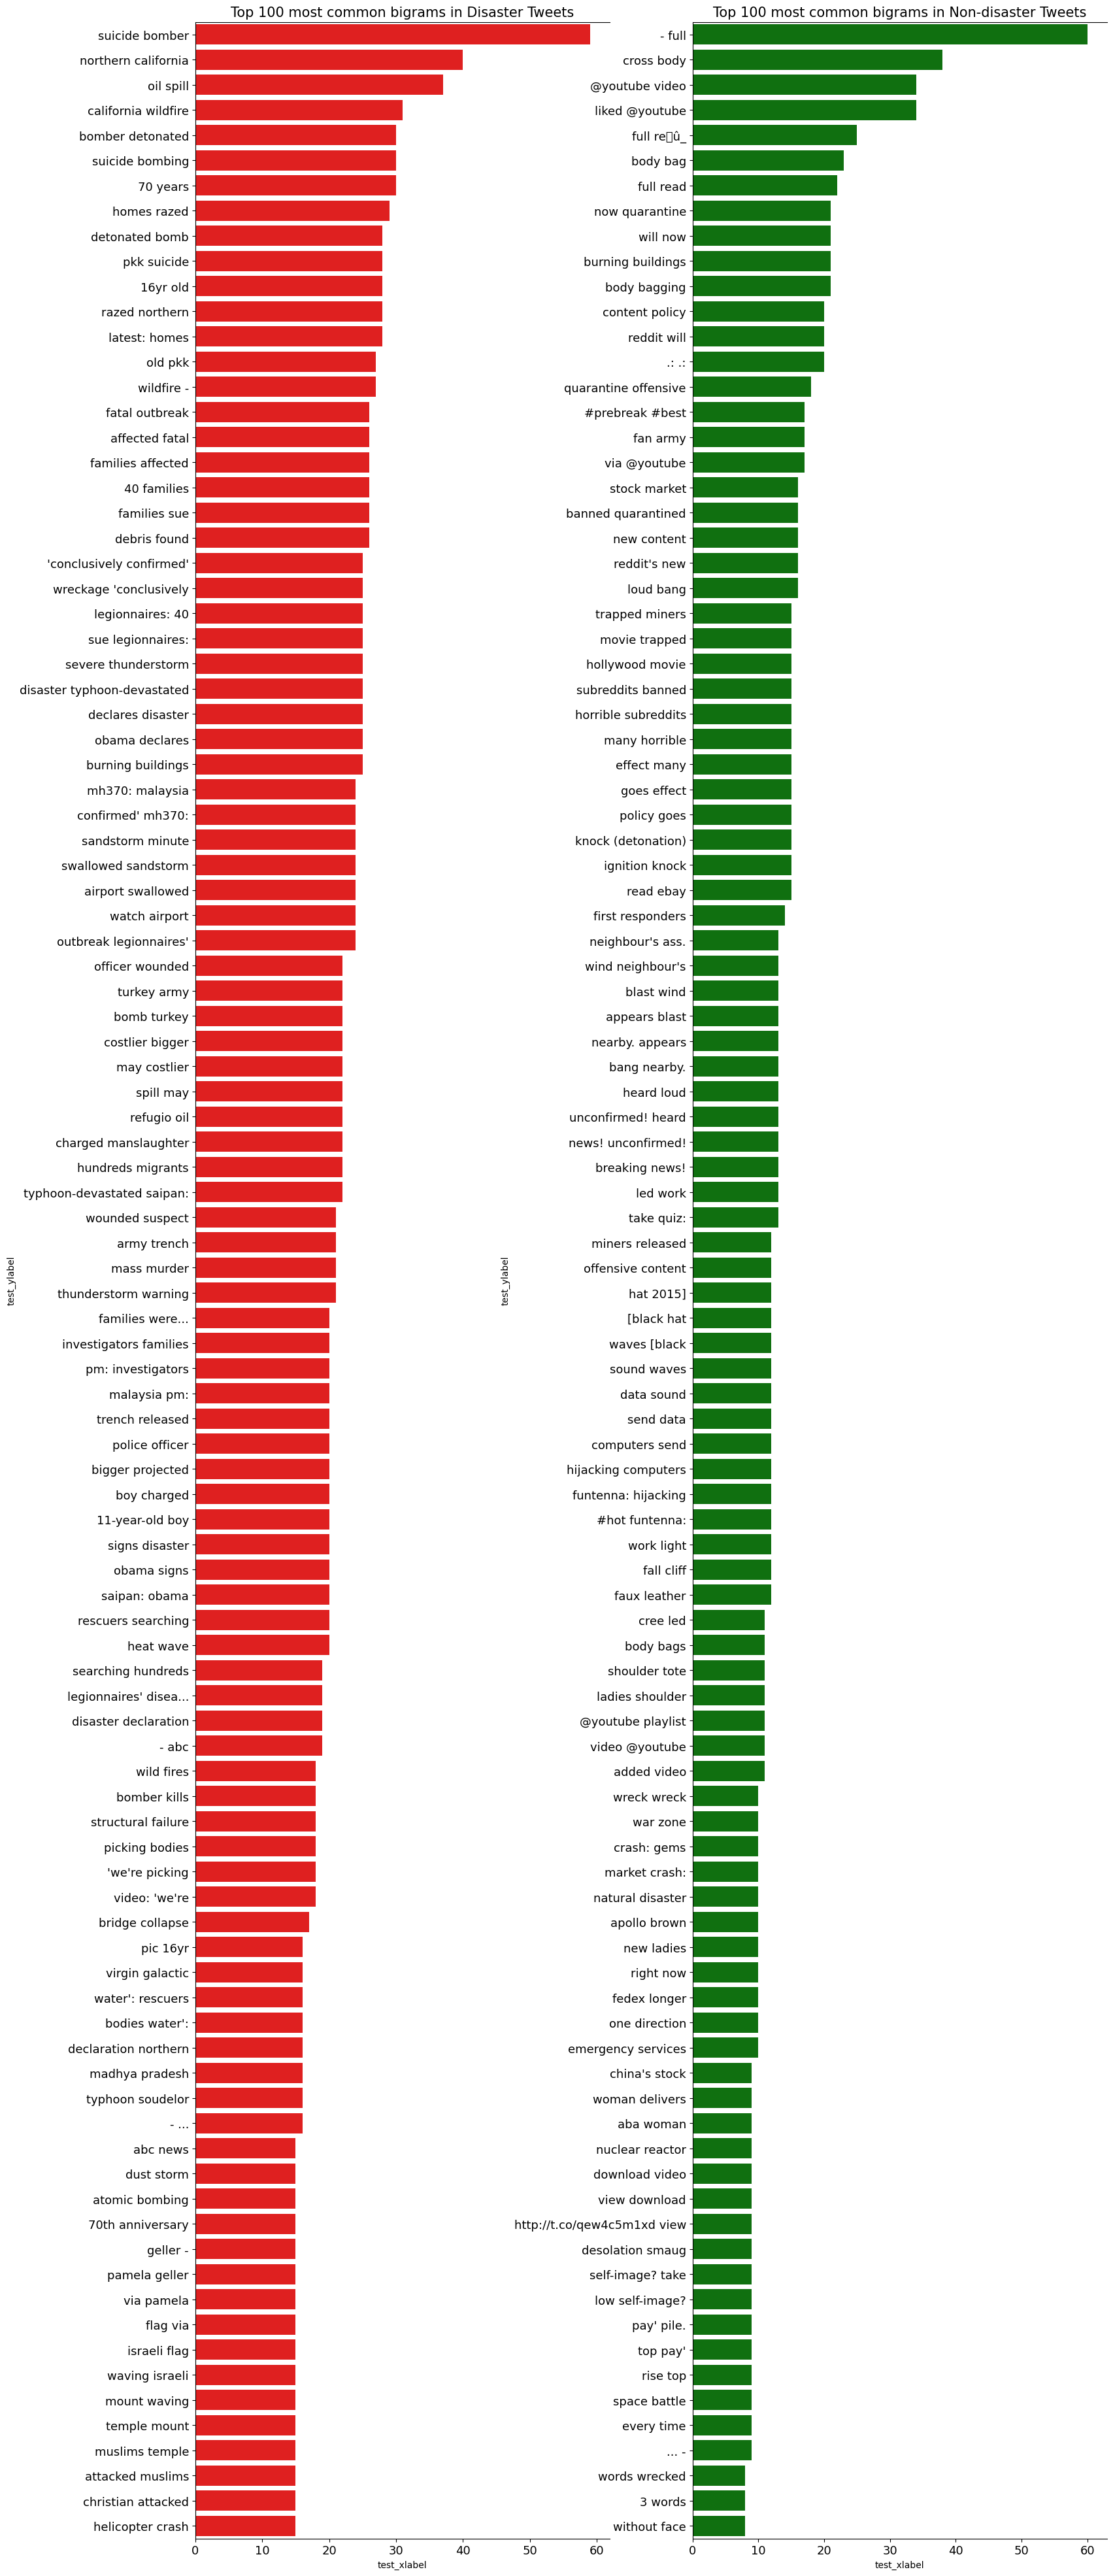

In [35]:
fig, axes = plt.subplots(ncols=2, figsize=(18, 50), dpi=100)
# plt.tight_layout()

sns.barplot(y=df_disaster_bigrams[0].values[:N], x=df_disaster_bigrams[1].values[:N], ax=axes[0], color='red')
sns.barplot(y=df_nondisaster_bigrams[0].values[:N], x=df_nondisaster_bigrams[1].values[:N], ax=axes[1], color='green')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('test_xlabel')
    axes[i].set_ylabel('test_ylabel')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)
    
axes[0].set_title(f'Top {N} most common bigrams in Disaster Tweets', fontsize=15)
axes[1].set_title(f'Top {N} most common bigrams in Non-disaster Tweets', fontsize=15)

plt.show()

## トライグラム

文脈がより明確なため、両方のクラスに共通のトライグラムは存在しない。<br>
<br>
災害ツイートの中の最も一般的なトライグラムは、バイグラムと非常に似ている。<br>
それらは災害について多くの情報を与えている。<br>
しかし、バイグラムと共に追加情報を提供しない場合がある。<br>
<br>
災害以外のツイートで最も一般的なトライグラムもバイグラムも非常に似ており、多くの句読点が含まれている。

/Users/yamaguchiayumiyume/.pyenv/versions/3.8.5/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 137 (\x89) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


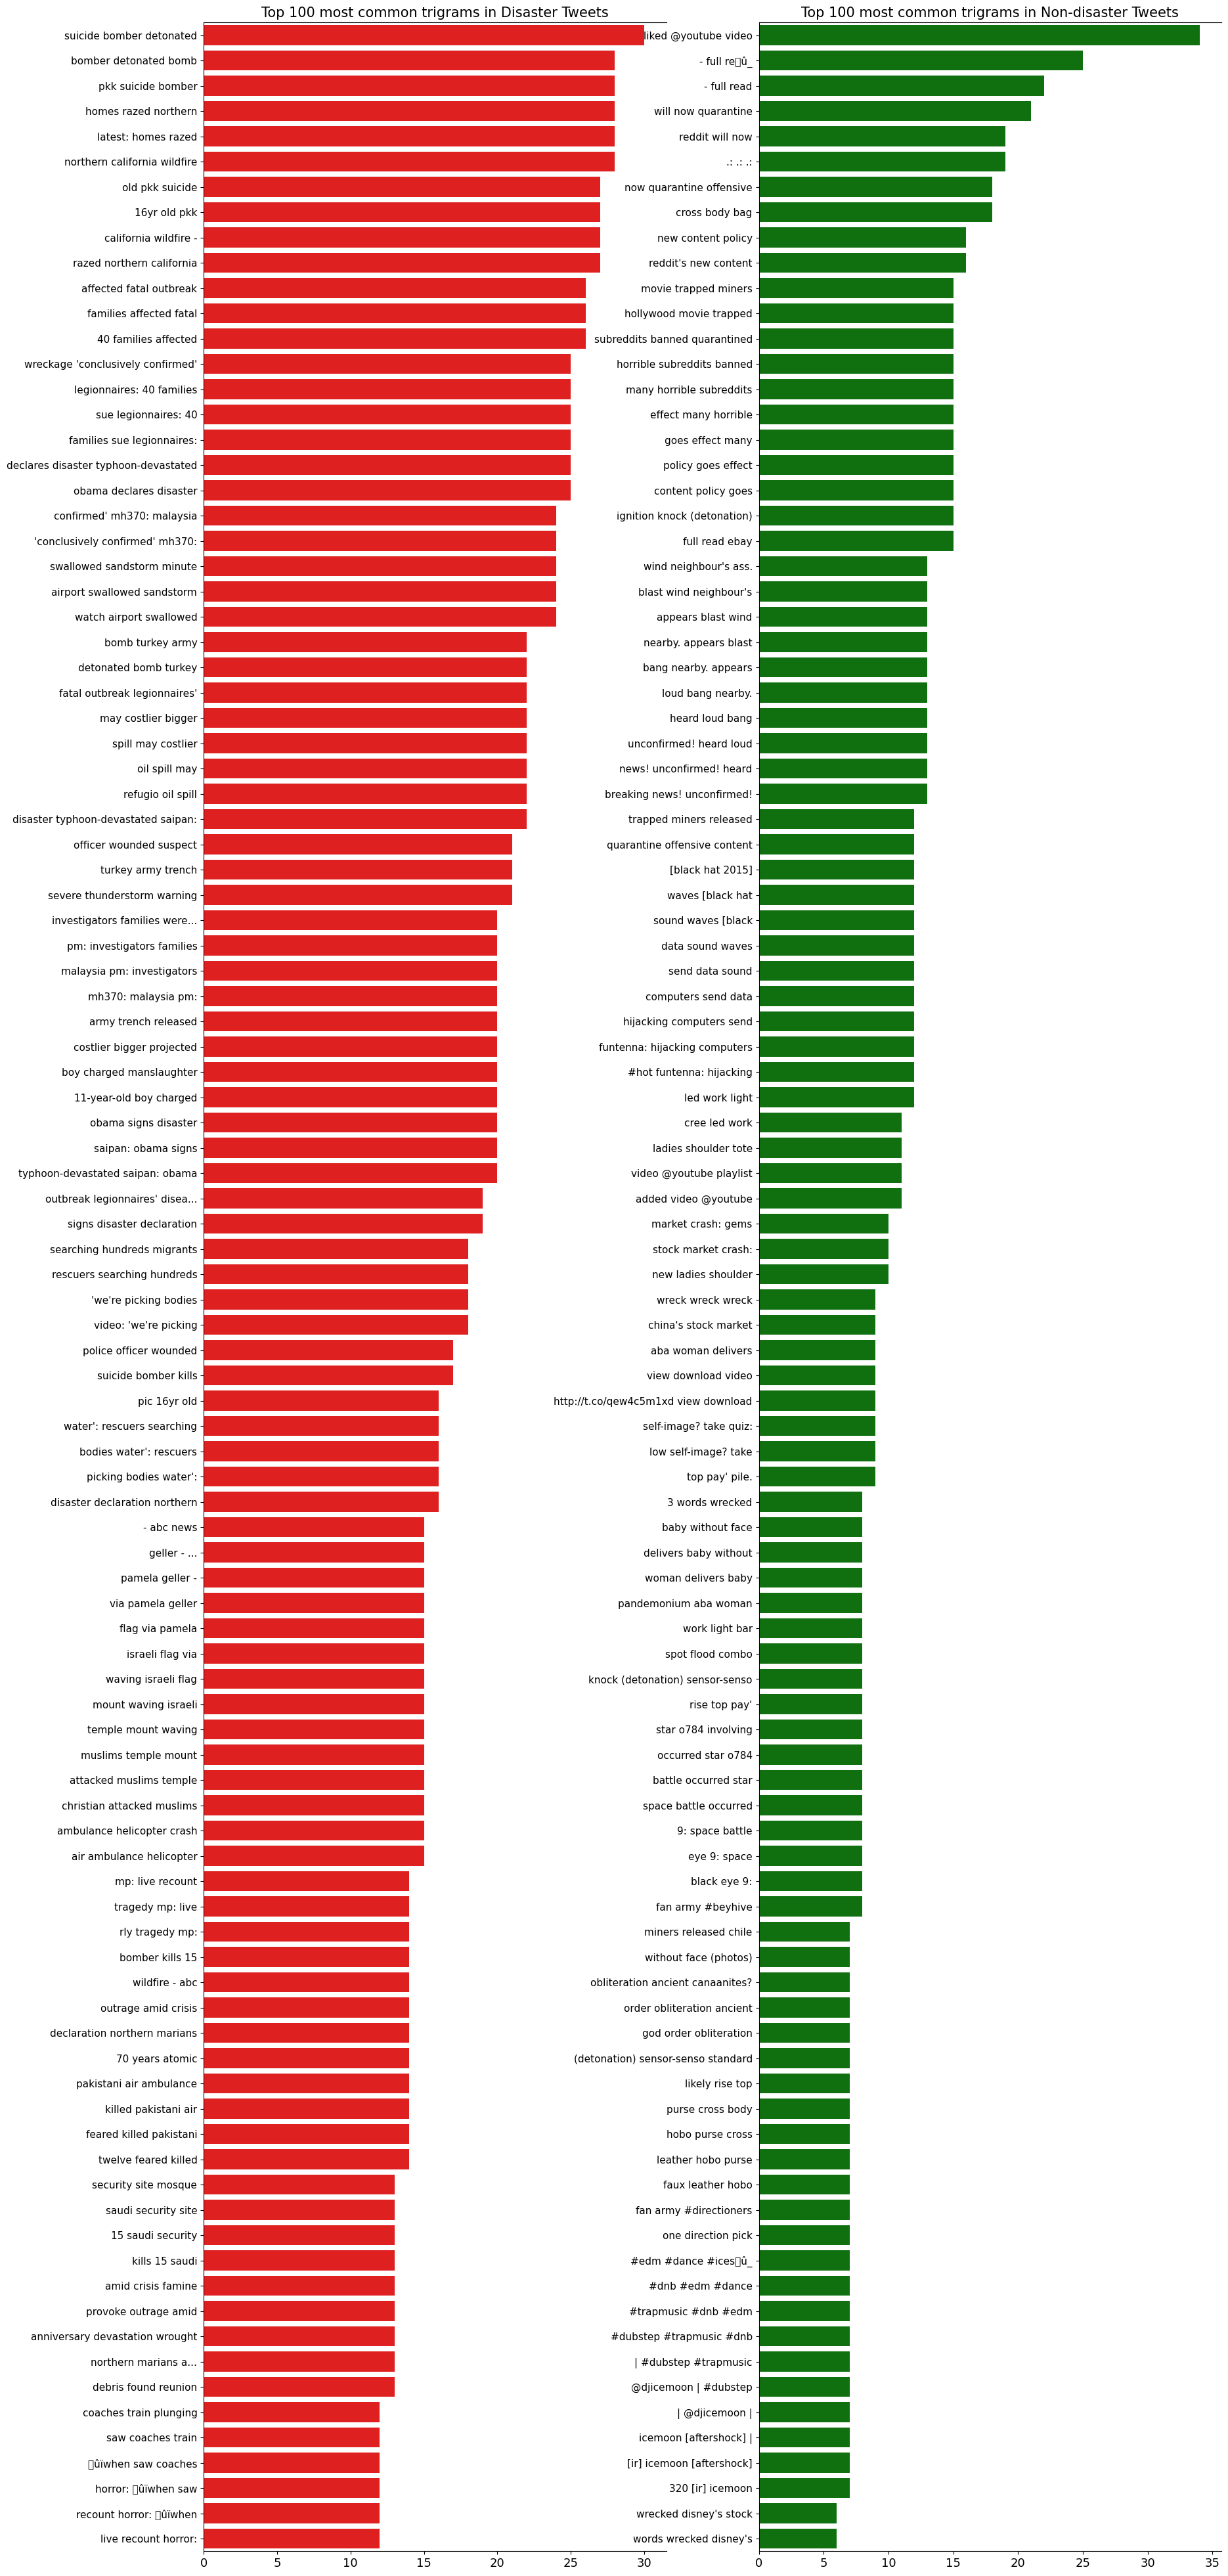

In [37]:
fig, axes = plt.subplots(ncols=2, figsize=(20, 50), dpi=100)

sns.barplot(y=df_disaster_trigrams[0].values[:N], x=df_disaster_trigrams[1].values[:N], ax=axes[0], color='red')
sns.barplot(y=df_nondisaster_trigrams[0].values[:N], x=df_nondisaster_trigrams[1].values[:N], ax=axes[1], color='green')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=11)

axes[0].set_title(f'Top {N} most common trigrams in Disaster Tweets', fontsize=15)
axes[1].set_title(f'Top {N} most common trigrams in Non-disaster Tweets', fontsize=15)

plt.show()

# 埋め込みと、テキストのクリーニング

## Embeddings Coverage
自然言語を計算が可能な状況に変換することを,embeddingと呼ぶ。

embeddingの事前学習をした時、基本的な前処理を行うことは良いアイデアかもしれない。<br>
なぜなら、いくつかの貴重な情報が失われる可能性があるから。<br>
<br>
ボキャブラリをできるだけembeddingに近づけるべき。
そのために、単語を数えてトレーニングデータをテストデータを作成する。

テキストクリーニングは下記のembeddingに基づいている。
* GloVe-300d-840B
* FastText-Crawl-300d-2M

In [ ]:
%%time
# np.load・・・pickleされたオブジェクトや配列を.npyや.npz形式のファイルやpickleされたファイルから読み込む。

glove_embeddings = np.load('glove.840B.300d.pkl', allow_pickle=True)
fasttext_embeddings = np.load('crawl-300d-2M.pkl', allow_pickle=True)